In [1]:
# Initial imports and notebook setup
%matplotlib inline
import matplotlib.pyplot as plt

import sys
import os
from copy import copy
from HARK.ConsumptionSaving.ConsGenIncProcessModel import (
    IndShockExplicitPermIncConsumerType,
    IndShockConsumerType,
    PersistentShockConsumerType,
    init_explicit_perm_inc
)
# import Demos.ConsumptionSaving.ConsumerParameters as Params

from HARK.utilities import plotFuncs
import numpy as np
from time import process_time

Classes to solve consumption-saving models with idiosyncratic shocks to income in which shocks are not necessarily fully transitory or fully permanent. This model extends $\texttt{ConsIndShockModel}$ by tracking persistent income $p_t$ as a state variable.

However, unlike in $\texttt{ConsIndShockModel}$, consumers do not necessarily have expected persistent income growth that is constant with respect to their current persistent income level. Instead, this model allows a generic function $\gimel$ to translate current persistent income into expected persistent income next period (subject to shocks). 



### Mathematical representation of GenIncProcess model:

The agent's problem can be written in Bellman form as:

\begin{eqnarray*}
v_t(M_t,p_t) &=& \max_{c_t} U(c_t) + \beta (1-\mathsf{D}_{t+1}) \mathbb{E} [v_{t+1}(M_{t+1}, p_{t+1}) ], \\
a_t &=& M_t - c_t, \\
a_t &\geq& \underline{a}, \\
M_{t+1} &=& R a_t + \theta_{t+1}, \\
p_{t+1} &=& \gimel_{t+1}(p_t)\psi_{t+1}, \\
\psi_t \sim F_{\psi t} &\qquad&  \theta_t \sim F_{\theta t}, \mathbb{E} [F_{\psi t}] = 1, \\
U(c) &=& \frac{c^{1-\rho}}{1-\rho}.
\end{eqnarray*}

The one period problem for this model is solved by the function $\texttt{solveConsGenIncProcess}$, which creates an instance of the class $\texttt{ConsGenIncProcessSolver}$. The class $\texttt{GenIncProcessConsumerType}$ extends $\texttt{IndShockConsumerType}$ to represents agents in this model. To construct an instance of this class, several  additional parameters must be passed to the constructor as shown in the table below (parameters can be either "primitive" or "constructed" if they have already built-in capabilities from previous codes).

| Param | Description | Code | Value | Constructed |
| :---: | --- | --- | --- | :---: |
| $\beta$ |Intertemporal discount factor  | $\texttt{DiscFac}$ | 0.96 | |
| $\rho $ |Coefficient of relative risk aversion | $\texttt{CRRA}$ | 2.0 | |
| $R $ | Risk free interest factor | $\texttt{Rfree}$ | 1.03 | |
| $1 - \mathsf{D}$ |Survival probability | $\texttt{LivPrb}$ | [list] | |
| $\underline{a} $ |Artificial borrowing constraint | $\texttt{BoroCnstArt}$ | 0.0 | | 
| $(none) $ |Indicator of whether $\texttt{vFunc}$ should be computed | $\texttt{vFuncBool}$ | 'True' | |
| $(none)$ |Indicator of whether $\texttt{cFunc}$ should use cubic lines | $\texttt{CubicBool}$ | 'False' |  |
| :---: | --- | --- | --- | :---: |
|$F $ |A list containing three arrays of floats, representing a discrete <br> approximation to the income process: <br>event probabilities, persistent shocks, transitory shocks | $\texttt{IncomeDstn}$ | - |$\surd$ |
| $\gimel$ |Expected persistent income next period | $\texttt{pLvlNextFunc}$ | - | $\surd$ |
| $ (none) $ | Array of "extra" end-of-period asset values | $\texttt{aXtraGrid}$ | - |$\surd$ |
| $ (none) $ |Array of time-varying persistent income levels | $\texttt{pLvlGrid}$ | - |$\surd$ |

To specify the income shock distribution in this model, we use some constructed inputs which are built from the expected attributes and have some parametric assumptions as shown in the table below.

*For each constructed input, below is a table listing the expected attribute to construct it and what parametric assumptions is used.*

| Constructed Input | Expected Attribute | Assumption | 
| :---: | --- | :---: |
|IncomeDstn| $\texttt{PermIncCount}$: Number of permanent income gridpoints in "body" <br> $\texttt{PermInc_tail_N}$: Number of permanent income gridpoints in each "tail"| PermIncCount =12 <br> PermInc_tail_N = 4 |
|pLvlNextFunc|$\texttt{pLvlInitMean}$: Mean of log initial *permanent* income <br> $\texttt{pLvlInitStd}$: Standard deviation of log initial permanent income|pLvlInitMean = 0.0 <br> pLvlInitStd  = 0.0 |
|pLvlGrid|$\texttt{pLvlPctiles}$: Percentiles of the distribution of persistent income <br> $\texttt{pLvl}$ in each period|Log normal distribution|
|aXtraGrid|$\texttt{aNrmInitMean}$: Mean of log initial assets <br> $\texttt{aNrmInitStd}$: Standard deviation of log initial assets |aNrmInitMean = 0.0  <br> aNrmInitStd  = 1.0 |


### Consumer with explicit Permanent income

Let's make a generic example of an **"explicit permanent income"** consumer with idiosyncratic shocks and create a specific parameter dictionary.

This agent type is identical to an $\texttt{IndShockConsumerType}$ but for explicitly tracking $\texttt{pLvl}$ as a state variable during solution.

In [2]:
# More parameters specific to "Explicit Permanent income" shock model
# IndShockExplicitPermIncConsumerType has cycles set to zero by default
# init_explicit_perm_inc['cycles'] = 0
init_explicit_perm_inc['PermIncCount'] = 12  # Number of permanent income gridpoints in "body"
init_explicit_perm_inc['PermInc_tail_N'] = 4 # Number of permanent income gridpoints in each "tail"

Let's now create an instance of the type of consumer we are interested in and solve this agent's problem with an infinite horizon (cycles=0).

In [3]:
print('The infinite horizon examples presented here use a grid of persistent income levels (pLvlGrid)')
print('based on percentiles of the long run distribution of pLvl for the given parameters. These percentiles')
print('are specified in the attribute pLvlPctiles. Here, the lowest percentile is ' + str(init_explicit_perm_inc['pLvlPctiles'][0]*100) + ' and the highest')
print('percentile is ' + str(init_explicit_perm_inc['pLvlPctiles'][-1]*100) + '.\n')

ExplicitExample = IndShockExplicitPermIncConsumerType(**init_explicit_perm_inc)
ExplicitExample.solve()

The infinite horizon examples presented here use a grid of persistent income levels (pLvlGrid)
based on percentiles of the long run distribution of pLvl for the given parameters. These percentiles
are specified in the attribute pLvlPctiles. Here, the lowest percentile is 0.1 and the highest
percentile is 99.9.



In the cell below, we generate a plot of the consumption function at different permanent income levels.

Consumption function by pLvl for explicit permanent income consumer:


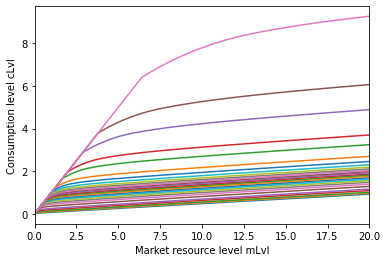

In [4]:
print('Consumption function by pLvl for explicit permanent income consumer:')
pLvlGrid = ExplicitExample.pLvlGrid[0]
mLvlGrid = np.linspace(0,20,300)
for p in pLvlGrid:
    M_temp = mLvlGrid + ExplicitExample.solution[0].mLvlMin(p)
    C = ExplicitExample.solution[0].cFunc(M_temp,p*np.ones_like(M_temp))
    plt.plot(M_temp,C)
plt.xlim(0.,20.)
plt.xlabel('Market resource level mLvl')
plt.ylabel('Consumption level cLvl')
plt.show()

### Permanent income normalized

An alternative model is to normalized it by dividing all variables by permanent income $p_t$ and solve the model again.

In [5]:
NormalizedExample = IndShockConsumerType(**init_explicit_perm_inc)
NormalizedExample.solve()

Normalized consumption function by pLvl for explicit permanent income consumer:


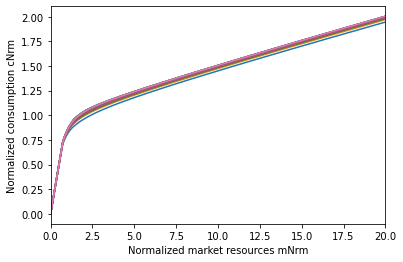

Consumption function for normalized problem (without explicit permanent income):


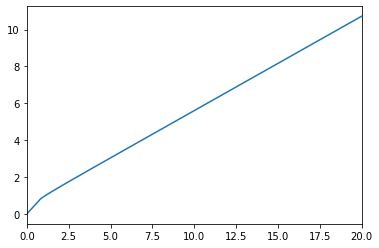

In [6]:
# Compare the normalized problem with and without explicit permanent income
print('Normalized consumption function by pLvl for explicit permanent income consumer:')
pLvlGrid = ExplicitExample.pLvlGrid[0]
mNrmGrid = np.linspace(0,20,300)
for p in pLvlGrid:
    M_temp = mNrmGrid*p + ExplicitExample.solution[0].mLvlMin(p)
    C = ExplicitExample.solution[0].cFunc(M_temp,p*np.ones_like(M_temp))
    plt.plot(M_temp/p,C/p)

plt.xlim(0.,20.)
plt.xlabel('Normalized market resources mNrm')
plt.ylabel('Normalized consumption cNrm')
plt.show()

print('Consumption function for normalized problem (without explicit permanent income):')
mNrmMin = NormalizedExample.solution[0].mNrmMin
plotFuncs(NormalizedExample.solution[0].cFunc,mNrmMin,mNrmMin+20.)

The figures show that the normalized consumption function for the "explicit permanent income" consumer is almost identical for every permanent income level (and the same as the normalized problem's $\texttt{cFunc}$), but is less accurate due to extrapolation outside the bounds of $\texttt{pLvlGrid}$. 

The "explicit permanent income" solution deviates from the solution to the normalized problem because of errors from extrapolating beyond the bounds of the $\texttt{pLvlGrid}$. The error is largest for $\texttt{pLvl}$ values near the upper and lower bounds, and propagates toward the center of the distribution.


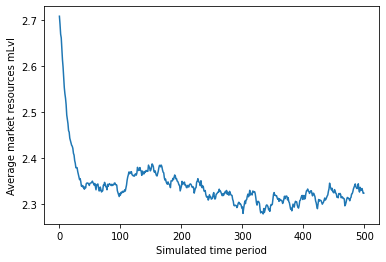

In [7]:
# Simulate many periods to get to the stationary distribution
ExplicitExample.T_sim = 500
ExplicitExample.track_vars = ['mLvlNow','cLvlNow','pLvlNow']
ExplicitExample.initializeSim()
ExplicitExample.simulate()
plt.plot(np.mean(ExplicitExample.history['mLvlNow'],axis=1))
plt.xlabel('Simulated time period')
plt.ylabel('Average market resources mLvl')
plt.show()

### Persistent income shock consumer

*--> On a separate Notebook ?*

Class to solve consumption-saving models with idiosyncratic shocks to income in which shocks are persistent and transitory. This model extends $\texttt{ConsGenIndShockModel}$ by allowing (log) persistent income to follow an AR(1) process.

The agent's problem can be written in Bellman form as:

\begin{eqnarray*}
v_t(M_t,p_t) &=& \max_{c_t} U(c_t) + \beta (1-\mathsf{D}_{t+1}) \mathbb{E} [v_{t+1}(M_{t+1}, p_{t+1}) ], \\
a_t &=& M_t - c_t, \\
a_t &\geq& \underline{a}, \\
M_{t+1} &=& R a_t + \theta_{t+1}, \\
log(p_{t+1}) &=& \varphi log(p_t)+(1-\varphi log( ) +log(\Gamma_{t+1})+log(\psi_{t+1}), \\
\\
\psi_t \sim F_{\psi t} &\qquad&  \theta_t \sim F_{\theta t}, \mathbb{E} [F_{\psi t}] = 1 \\
\end{eqnarray*}

| Param | Description | Code | Value | Constructed |
| :---: | --- | --- | --- | :---: |
||||||
||||||



In [8]:
PersistentExample = PersistentShockConsumerType()
t_start = process_time()
PersistentExample.solve()
t_end = process_time()
print("Solving a persistent income shocks consumer took " + str(t_end - t_start) + " seconds.")

Solving a persistent income shocks consumer took 8.310017000000002 seconds.


Consumption function by persistent income level pLvl for a consumer with AR1 coefficient of 0.98:


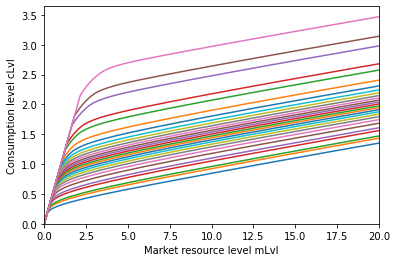

In [9]:
# Plot the consumption function at various levels of persistent income pLvl
print(
    "Consumption function by persistent income level pLvl for a consumer with AR1 coefficient of "
    + str(PersistentExample.PrstIncCorr)
    + ":"
)
pLvlGrid = PersistentExample.pLvlGrid[0]
mLvlGrid = np.linspace(0, 20, 300)
for p in pLvlGrid:
    M_temp = mLvlGrid + PersistentExample.solution[0].mLvlMin(p)
    C = PersistentExample.solution[0].cFunc(M_temp, p * np.ones_like(M_temp))
    plt.plot(M_temp, C)
plt.xlim(0.0, 20.0)
plt.ylim(0.0, None)
plt.xlabel("Market resource level mLvl")
plt.ylabel("Consumption level cLvl")
plt.show()

In [10]:
# Plot the value function at various persistent income levels
if PersistentExample.vFuncBool:
    pGrid = PersistentExample.pLvlGrid[0]
    M = np.linspace(0.001, 5, 300)
    for p in pGrid:
        M_temp = M + PersistentExample.solution[0].mLvlMin(p)
        C = PersistentExample.solution[0].vFunc(M_temp, p * np.ones_like(M_temp))
        plt.plot(M_temp, C)
    plt.ylim([-200, 0])
    plt.xlabel("Market resource level mLvl")
    plt.ylabel("Value v")
    plt.show()

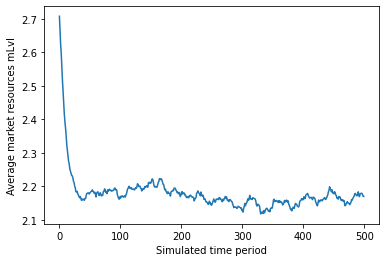

In [11]:
# Simulate some data
PersistentExample.T_sim = 500
PersistentExample.track_vars = ["mLvlNow", "cLvlNow", "pLvlNow"]
PersistentExample.initializeSim()
PersistentExample.simulate()
plt.plot(np.mean(PersistentExample.history['mLvlNow'], axis=1))
plt.xlabel("Simulated time period")
plt.ylabel("Average market resources mLvl")
plt.show()